In [4]:
# BASE IMPORT
import os
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2

In [5]:
import tensorflow as tf
from keras import layers
from keras import losses
from keras.models import Model
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from sklearn.metrics import accuracy_score
tf.config.run_functions_eagerly(True)

In [6]:
ROOT_DIR = os.getcwd()
INPUT_SHAPE = (256,256)

In [7]:
def real_path(*p:str):
    return os.path.realpath(os.path.join(*p))

In [8]:
def absolute_path(*p:str):
    return real_path(ROOT_DIR, *p)

In [9]:
def make_binary_label(labels:list, unique_labelnames:list, dtype='float32'):
    binary_label_shape = (len(unique_labelnames))
    labelnames_processed = np.array(unique_labelnames)
    labelnames_processed.sort()

    dict_labels = {}

    for i, item in enumerate(labelnames_processed):
        dict_labels[item] = int(i)
    
    labels_processed = []
    for label in labels:
        index = dict_labels[label]
        binary_label = np.zeros(binary_label_shape, dtype=dtype)
        binary_label[index] = 1.
        labels_processed.append(binary_label)

    labels_processed = np.array(labels_processed, dtype='float32')
    return labels_processed, labelnames_processed

In [10]:
def trim_data(x:np.ndarray, y:np.ndarray):
    
    if x.shape[0] != y.shape[0]:
        print('ERROR: Dataset length of x must be equal to length of y')
        return x, y

    original_size = x.shape[0]
    max_size = int(original_size/8)*8

    if max_size == original_size:
        return x, y
        
    return x[:max_size], y[:max_size]

In [12]:
def load_images_from_dir(dataset_dir, prev_processing_function=None, normalize_label=True):
    # os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

    # init
    absolute_data_dir = os.path.realpath(dataset_dir)

    images = []
    labels = []
    labels_mames = []

    print(f'\n[i] Đang load và xử lý image\n')
    for dir_path, dirnames, filenames in os.walk(absolute_data_dir):
        #! if folder was empty
        if len(filenames) == 0:
            continue
        
        label_name = dir_path.replace(absolute_data_dir, '').replace('\\', '/').strip('/')
        labels_mames.append(label_name)

        print(f'          + Dir: "{dir_path}"')
        print(f'          + Label: {label_name}')
        for i, filename in enumerate(filenames):
            absolute_file_path = os.path.realpath(os.path.join(dir_path, filename))

            if not prev_processing_function:
                img = cv2.imread(absolute_file_path)
            else:
                img = prev_processing_function(cv2.imread(absolute_file_path))
                
            images.append(img)
            labels.append(label_name)
            #if
        #for
        print('')
    #for

    final_images = np.array(images, dtype="float32")
    final_labels, final_labelmames = make_binary_label(labels, labels_mames)

    print(f'[=>] Tổng số image đã load và xử lý: {len(final_images)} image')
    print(f'[=>] Labels: {str(final_labelmames)}\n')

    print('[END loadImageFromDir]\n')
    return final_images, final_labels, final_labelmames

    

In [13]:
def pre_processing_image(img:np.ndarray):
    img_result = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_result = cv2.resize(img, dsize=INPUT_SHAPE)
    img_result = img_result/255
    return img_result

In [14]:
def make_model(number_objects:int):
    base_model = InceptionResNetV2(
        input_shape=(INPUT_SHAPE[0], INPUT_SHAPE[1], 3),
        weights='imagenet',
        include_top=False
    )
    
    for layer in base_model.layers:
        layer.trainable=False

    X=layers.Flatten()(base_model.output)
    X=layers.Dense(units=number_objects, activation='softmax')(X)
    model = Model(base_model.input, X)
    model.compile(optimizer='adam', loss=losses.categorical_crossentropy, metrics=['accuracy'])
    return model

In [15]:
def predict_to_index(y:np.ndarray):
    return [np.argmax(item) for item in y]

In [16]:
TRAIN_DIR = absolute_path('./Model_Data/Train/')
VAL_DIR = absolute_path('./Model_Data/Val/')
TEST_DIR = absolute_path('./Model_Data/Test/')
LABELS = os.listdir(TRAIN_DIR)
LABEL_DIRS = [real_path(TRAIN_DIR, label_dirname) for label_dirname in LABELS]
NUMBER_OF_OBJECT = len(LABEL_DIRS)
print(LABELS)

['Amanda Crew', 'barack obama', 'Maria Pedraza', 'Natalie Dormer', 'NON-TARGET', 'tom ellis']


In [17]:
train_x, train_y, labels_names = load_images_from_dir(TRAIN_DIR, pre_processing_image)


[i] Đang load và xử lý image

          + Dir: "C:\Resources\workspaces\ml\le-van-duc-anh\BaitapLon\BaitapLon\Model_Data\Train\Amanda Crew"
          + Label: Amanda Crew

          + Dir: "C:\Resources\workspaces\ml\le-van-duc-anh\BaitapLon\BaitapLon\Model_Data\Train\barack obama"
          + Label: barack obama

          + Dir: "C:\Resources\workspaces\ml\le-van-duc-anh\BaitapLon\BaitapLon\Model_Data\Train\Maria Pedraza"
          + Label: Maria Pedraza

          + Dir: "C:\Resources\workspaces\ml\le-van-duc-anh\BaitapLon\BaitapLon\Model_Data\Train\Natalie Dormer"
          + Label: Natalie Dormer

          + Dir: "C:\Resources\workspaces\ml\le-van-duc-anh\BaitapLon\BaitapLon\Model_Data\Train\NON-TARGET"
          + Label: NON-TARGET

          + Dir: "C:\Resources\workspaces\ml\le-van-duc-anh\BaitapLon\BaitapLon\Model_Data\Train\tom ellis"
          + Label: tom ellis

[=>] Tổng số image đã load và xử lý: 668 image
[=>] Labels: ['Amanda Crew' 'Maria Pedraza' 'NON-TARGET' 'Natali

In [18]:
val_x, val_y, _ = load_images_from_dir(VAL_DIR, pre_processing_image)


[i] Đang load và xử lý image

          + Dir: "C:\Resources\workspaces\ml\le-van-duc-anh\BaitapLon\BaitapLon\Model_Data\Val\Amanda Crew"
          + Label: Amanda Crew

          + Dir: "C:\Resources\workspaces\ml\le-van-duc-anh\BaitapLon\BaitapLon\Model_Data\Val\barack obama"
          + Label: barack obama

          + Dir: "C:\Resources\workspaces\ml\le-van-duc-anh\BaitapLon\BaitapLon\Model_Data\Val\Maria Pedraza"
          + Label: Maria Pedraza

          + Dir: "C:\Resources\workspaces\ml\le-van-duc-anh\BaitapLon\BaitapLon\Model_Data\Val\Natalie Dormer"
          + Label: Natalie Dormer

          + Dir: "C:\Resources\workspaces\ml\le-van-duc-anh\BaitapLon\BaitapLon\Model_Data\Val\NON-TARGET"
          + Label: NON-TARGET

          + Dir: "C:\Resources\workspaces\ml\le-van-duc-anh\BaitapLon\BaitapLon\Model_Data\Val\tom ellis"
          + Label: tom ellis

[=>] Tổng số image đã load và xử lý: 285 image
[=>] Labels: ['Amanda Crew' 'Maria Pedraza' 'NON-TARGET' 'Natalie Dormer'
 '

In [19]:
test_x, test_y, _ = load_images_from_dir(TEST_DIR, pre_processing_image)


[i] Đang load và xử lý image

          + Dir: "C:\Resources\workspaces\ml\le-van-duc-anh\BaitapLon\BaitapLon\Model_Data\Test\Amanda Crew"
          + Label: Amanda Crew

          + Dir: "C:\Resources\workspaces\ml\le-van-duc-anh\BaitapLon\BaitapLon\Model_Data\Test\barack obama"
          + Label: barack obama

          + Dir: "C:\Resources\workspaces\ml\le-van-duc-anh\BaitapLon\BaitapLon\Model_Data\Test\Maria Pedraza"
          + Label: Maria Pedraza

          + Dir: "C:\Resources\workspaces\ml\le-van-duc-anh\BaitapLon\BaitapLon\Model_Data\Test\Natalie Dormer"
          + Label: Natalie Dormer

          + Dir: "C:\Resources\workspaces\ml\le-van-duc-anh\BaitapLon\BaitapLon\Model_Data\Test\NON-TARGET"
          + Label: NON-TARGET

          + Dir: "C:\Resources\workspaces\ml\le-van-duc-anh\BaitapLon\BaitapLon\Model_Data\Test\tom ellis"
          + Label: tom ellis

[=>] Tổng số image đã load và xử lý: 485 image
[=>] Labels: ['Amanda Crew' 'Maria Pedraza' 'NON-TARGET' 'Natalie Dorm

In [20]:
train_x_trimmed, train_y_trimmed = trim_data(train_x, train_y)
val_x_trimmed, val_y_trimmed = trim_data(val_x, val_y)
print(train_x_trimmed.shape)
print(train_y_trimmed.shape)
print(val_x_trimmed.shape)
print(val_y_trimmed.shape)

(664, 256, 256, 3)
(664, 6)
(280, 256, 256, 3)
(280, 6)


In [21]:
model = make_model(len(labels_names))

In [22]:
history = model.fit(
    x=train_x_trimmed,
    y=train_y_trimmed,
    validation_data=(val_x_trimmed, val_y_trimmed),
    batch_size=8,
    validation_batch_size=8,
    epochs=3
)
model.save(absolute_path('./weights/nguoi-noi-tieng.h5'), save_format='h5')

c:\lapis\program_files\python39\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/3
83/83 [==============================] - 560s 7s/step - loss: 5.4899 - accuracy: 0.4895 - val_loss: 3.0782 - val_accuracy: 0.6429
Epoch 2/3
83/83 [==============================] - 638s 8s/step - loss: 1.5810 - accuracy: 0.8117 - val_loss: 3.1191 - val_accuracy: 0.7571
Epoch 3/3
83/83 [==============================] - 566s 7s/step - loss: 0.7730 - accuracy: 0.8705 - val_loss: 1.7961 - val_accuracy: 0.8929


In [23]:
pred_y = model.predict(test_x)

In [24]:
accuracy_score(predict_to_index(test_y), predict_to_index(pred_y))

0.8721649484536083

c:\lapis\program_files\python39\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


true Amanda Crew
predict NON-TARGET


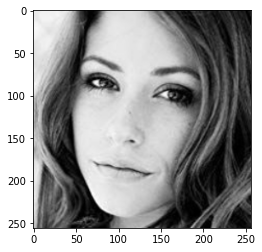



-------------


true Amanda Crew
predict Amanda Crew


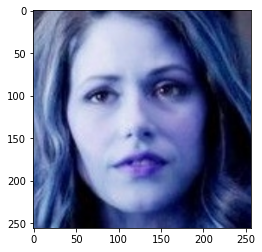



-------------


true Natalie Dormer
predict Natalie Dormer


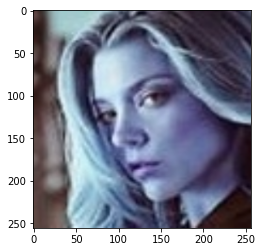



-------------


true tom ellis
predict tom ellis


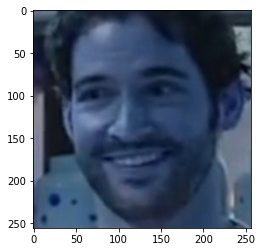



-------------


true Amanda Crew
predict Amanda Crew




-------------


true NON-TARGET
predict NON-TARGET




-------------


true Amanda Crew
predict Amanda Crew


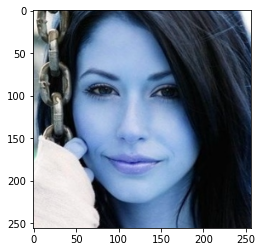



-------------


true NON-TARGET
predict NON-TARGET


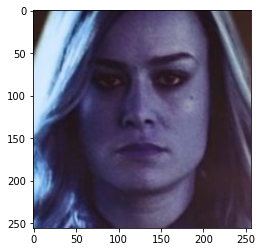



-------------


true Natalie Dormer
predict Natalie Dormer


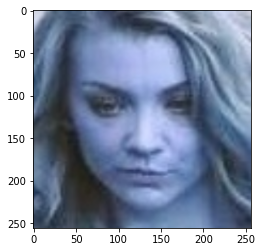



-------------


true tom ellis
predict tom ellis


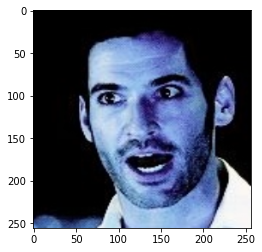



-------------




In [25]:
size_test = test_x.shape[0]
for i in range(0, 10):
    index = random.randint(0, size_test-1)

    y_pred = predict_to_index([model.predict(np.array([test_x[index]]))])
    y_true = predict_to_index([test_y[index]])

    print('true', labels_names[y_true[0]])
    print('predict', labels_names[y_pred[0]])

    plt.figure()
    plt.imshow(test_x[index])
    plt.show()

    print('\n\n-------------\n\n')
